<a href="https://colab.research.google.com/github/YeongLee-Smart/SUMAN/blob/main/20240927_model_4_feedback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#딥러닝 모델을 만든 이유(피드백): 신용카드 이상거래가 데이터상에서 측정되어, 딥러닝 모델을 활용하여 효과적으로 신용카드 이상거래를 탐지 하기 위함

#Module

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score, classification_report, roc_curve, auc, roc_auc_score
from imblearn.over_sampling import SMOTE # For Oversampling
from sklearn.preprocessing import MinMaxScaler # Data Normalization (각 특징에 대해 0~1 사이 값으로 변환)
from sklearn.model_selection import StratifiedKFold #TrainData, TestData 분리(K-fold)
from sklearn.model_selection import train_test_split #피드백으로 추가한 부분
import xgboost as xgb
from xgboost import cv

# Data Load

In [ ]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/creditcard.csv'
data = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EDA

In [ ]:
# data.info() #결측치 없음
data['Class'].value_counts()

,count
Class,
0,284315
1,492


# 원본 데이터 시각화

<ipython-input-31-993f4f3db8c2>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


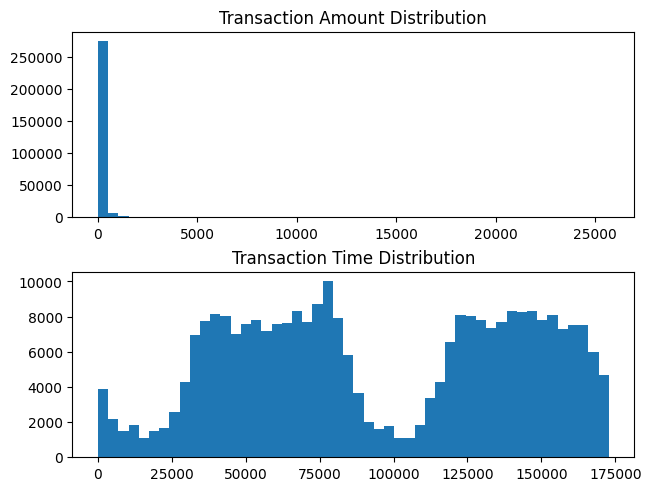

In [ ]:
amount_original = data['Amount'].values
time_original = data['Time'].values

plt.subplots(constrained_layout=True)

plt.subplot(2, 1, 1)
plt.title('Transaction Amount Distribution')
plt.hist(amount_original, bins=50)

plt.subplot(2, 1, 2)
plt.title('Transaction Time Distribution')
plt.hist(time_original, bins=50)

plt.show()

# TrainData TestData 분리, Oversampling, Data Normalization

##Kfold 할때 test셋을 먼저 빼놓고 나머지 80으로 kfold했어야한다(Training Data를 만들었어야만 했다).

In [ ]:
# 1. X, y 분리
X= data.iloc[:, :-1] # Time~Amount
Y= data.iloc[:, -1] # Class

# 2. 데이터 정규화 (각 특징에 대해 0~1 사이 값으로 변환), 데이터 분리전 데이터 정규화를 하도록 코드 순서 변경(피드백)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X) # X데이터를 scaling
X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns) # X_scaled는 numpy이므로 DataFrame으로 변경

# 3. Train Data와 Test Data 분리(피드백으로 추가한 부분) #XGBoost라서 오버샘플링 필요x
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
# dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
# dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

#3-2.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=156)

dtrain = xgb.DMatrix(data = X_train, label = y_train)
dtest = xgb.DMatrix(data = X_test, label = y_test)

# 9999참고블로그->. https://romg2.github.io/mlguide/03_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C-04.-%EB%B6%84%EB%A5%98-XGBoost/

In [ ]:
params = {
    "max_depth": 3,
    "eta": 0.1,
    "objective": "binary:logistic",
    "eval_metric": "logloss"
    # "early_stoppings": 100
}

num_rounds = 400 # 부스팅 반복 횟수


# XGB 학습

# evals 파라미터에 train, test 셋을 명기하면 평가를 진행하면서 조기 중단을 적용 할 수 있다.
wlist = [(dtrain, "train"), (dtest, "eval")]

# 모델 학습: 사이킷런과 달리 train() 함수에 파라미터를 전달한다.
xgb_model = xgb.train(params = params, verbose_eval= 40, dtrain = dtrain, num_boost_round = num_rounds,
                      evals = wlist)


# 예측 확률
pred_probs = xgb_model.predict(dtest)
print("predict() 수행 결과값 10개만 표시")
print(pred_probs[:10])

# 예측 분류
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print("예측 분류 10개만 표시")
print(f"{preds[:10]}")

# 3장에서 사용한 성능 평가 함수
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba_po=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba_po)

    print("오차 행렬")
    print(confusion)
    print(f"정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

get_clf_eval(y_test, pred = preds, pred_proba_po = pred_probs)



[0]	train-logloss:0.11743	eval-logloss:0.11800
[40]	train-logloss:0.00422	eval-logloss:0.00449
[80]	train-logloss:0.00202	eval-logloss:0.00288
[120]	train-logloss:0.00153	eval-logloss:0.00280
[160]	train-logloss:0.00121	eval-logloss:0.00275
[200]	train-logloss:0.00097	eval-logloss:0.00272
[240]	train-logloss:0.00077	eval-logloss:0.00271
[280]	train-logloss:0.00059	eval-logloss:0.00273
[320]	train-logloss:0.00047	eval-logloss:0.00276
[360]	train-logloss:0.00036	eval-logloss:0.00279
[399]	train-logloss:0.00029	eval-logloss:0.00284
predict() 수행 결과값 10개만 표시
[1.2290495e-05 1.1948322e-06 7.9869415e-07 9.2783439e-06 1.4071044e-06
 3.9472266e-06 6.9946736e-07 1.3736264e-05 8.9308087e-06 1.5921908e-06]
예측 분류 10개만 표시
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
오차 행렬
[[56841     5]
 [   20    96]]
정확도: 0.9996, 정밀도: 0.9505, 재현율: 0.8276, F1: 0.8848, AUC: 0.9797


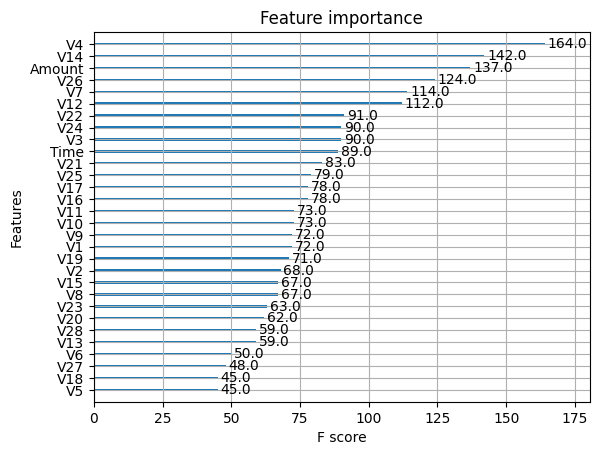

In [ ]:
from xgboost import plot_importance

plot_importance(xgb_model)
plt.show()

**xgb 시각화**

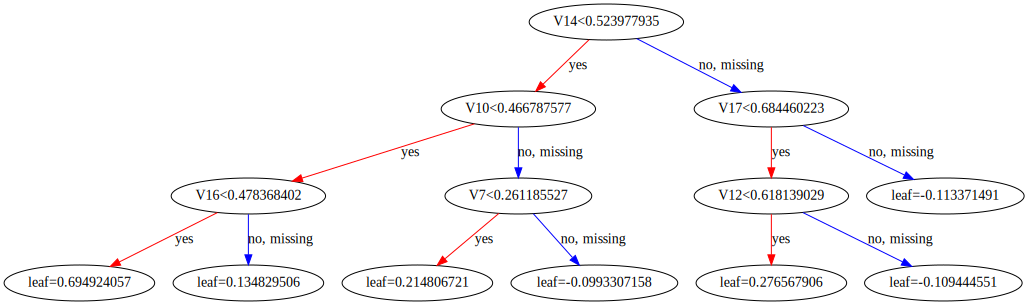

In [ ]:
from xgboost import to_graphviz
import graphviz

to_graphviz(xgb_model)

**XGB 교차검증**

In [ ]:
xgb.cv(params=params, dtrain=dtrain, num_boost_round=10, nfold=3, metrics="logloss")

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.117438,0.000019,0.117453,0.000021
1,0.105593,0.000030,0.105623,0.000035
2,0.095085,0.000039,0.095129,0.000051
3,0.085719,0.000047,0.085770,0.000058
4,0.077352,0.000055,0.077413,0.000067
5,0.069862,0.000062,0.069932,0.000075
6,0.063147,0.000066,0.063226,0.000084
7,0.057120,0.000070,0.057206,0.000085
8,0.051708,0.000072,0.051800,0.000095
9,0.046846,0.000076,0.046945,0.000101


(전)

In [ ]:
# 4. Oversampling(피드백으로 Oversampling 알고리즘 변경
smote = SMOTE(random_state=0)
X_resampled, Y_resampled = smote.fit_resample(X_train, y_train)

# 5. train, test 분리
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

for train_index, val_index in kfold.split(X_resampled, Y_resampled):
    X_train, X_val = X_resampled.iloc[train_index], X_resampled.iloc[val_index]
    y_train, y_val = Y_resampled.iloc[train_index], Y_resampled.iloc[val_index]

print(X_train.shape, y_train.shape) #(363904, 30) (363904,) 80% (Test_Set 없음)
print(X_val.shape, y_val.shape) #(90976, 30) (90976,) 20% (Test_Set 없음)


(363904, 30) (363904,)
(90976, 30) (90976,)


후

*이탤릭체 텍스트*

In [ ]:
model1 = xgb.XGBClassifier()
train_model1 = model1.fit(X_train, y_train)
# print(train_model1)
# 예측 수행
y_pred1 = model1.predict(X_test)
# 정확도
accuracy1 = accuracy_score(y_test, y_pred1)
# Recall
recall1 = recall_score(y_test, y_pred1)
print(accuracy1)
print(recall1)

0.9995611109160493
0.7701149425287356


In [ ]:
from sklearn.metrics import mean_squared_error
# 4. XGBoost 모델 설정
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.01,
    'max_depth': 6,
    'alpha': 0.1,  #과적합방지 /
    'lambda': 1, #과적합방지 노이즈 잡아줌
    'seed': 1
}


n = 100
model = xgb.train(
   verbose_eval=40,
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals = wlist
)
preds = model.predict(dtest_reg)
rmse = mean_squared_error(y_test, preds, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")

[0]	train-logloss:0.12964	eval-logloss:0.13038
[40]	train-logloss:0.08502	eval-logloss:0.08537
[80]	train-logloss:0.05663	eval-logloss:0.05683
[99]	train-logloss:0.04687	eval-logloss:0.04703
RMSE of the base model: 0.066


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
Y_resampled.value_counts() #Over Sampling check, 피드백대로 수정한 결과 28만개에서 22만개로 감소

,count
Class,
0,227440
1,227440


# 정규화된 데이터 시각화

<ipython-input-42-174f209d2bbb>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


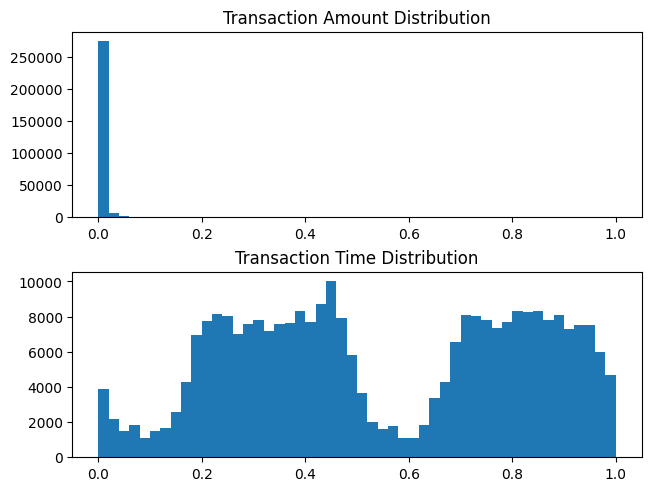

In [ ]:
amount_normalized = X['Amount'].values
time_normalized = X['Time'].values

plt.subplots(constrained_layout=True)

plt.subplot(2, 1, 1)
plt.title('Transaction Amount Distribution')
plt.hist(amount_normalized, bins=50)

plt.subplot(2, 1, 2)
plt.title('Transaction Time Distribution')
plt.hist(time_normalized, bins=50)

plt.show()

# Hyperparameter

## learning_rate_decay 변경
     exponential -> cosine -> inverse


##EXP(Learning_Rate_Decay)

In [ ]:
# 초기값 설정
initial_learning_rate = 0.01
decay_steps = 5
decay_rate = 0.95
epochs = np.arange(1, 101)

#Exponential Decay
exponential_decay = tf.keras.optimizers.schedules.ExponentialDecay(
     initial_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate
 )


# 2. 배치크기
batch_size = 2**12 #13만 #train 데이터의 약 50%크기

##Cosine Decay(Learning_Rate_Decay)

In [ ]:
#Cosine Decay
CosineDecayValue=tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.01,
    decay_steps=100,
    alpha=0.001,
    # name='CosineDecay',
    warmup_target=None,
    warmup_steps=0
)
epochs = np.arange(1, 101)

# 2. 배치크기
batch_size = 2**12 #13만 #train 데이터의 약 50%크기

##Inverse(Learning_Rate_Decay)

In [ ]:
#Inverse
InverseValue=tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=20,
    decay_rate=0.95,
    staircase=False,
    name='InverseTimeDecay'
)
epochs = np.arange(1, 101)

# 2. 배치크기
batch_size = 2**12 #13만 #train 데이터의 약 50%크기

## Learning Rate Decay Visualization

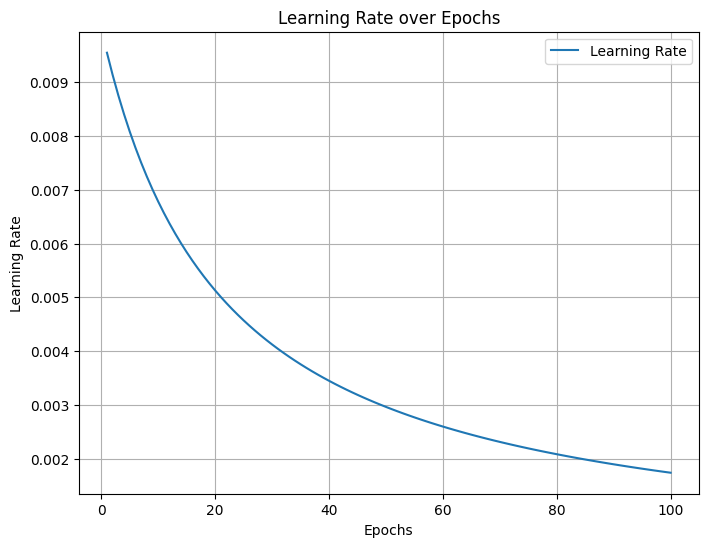

In [ ]:
# Learning_Rate 체크
learning_rate_check = []
for epoch in epochs:
    learning_rate = InverseValue(epoch)
    learning_rate_check.append(learning_rate.numpy())

# 학습율 시각화
plt.figure(figsize=(8, 6))
plt.plot(epochs, learning_rate_check, label='Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Model 구축

## Model 초기화

In [ ]:
print(X_train.shape[1])

30


In [ ]:
model = Sequential()

#가중치 초기화(Weight Initailization)
# weight_init = tf.keras.initializers.he_uniform()
# weight_init = tf.keras.initializers.RandomNormal()
weight_init = tf.keras.initializers.glorot_uniform()

#model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu', input_dim=30, kernel_initializer=weight_init))  # 첫 번째 은닉층
model.add(Dropout(0.5)) # 50% 드롭아웃 적용
model.add(Dense(64, activation='relu',kernel_initializer=weight_init))  # 두 번째 은닉층
model.add(Dropout(0.5))  # 50% 드롭아웃 적용
model.add(Dense(32, activation='relu',kernel_initializer=weight_init)) # 세 번째 은닉층
model.add(Dense(1, activation='sigmoid'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           3,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,337 (56.00 KB)

 Trainable params: 14,337 (56.00 KB)

 Non-trainable params: 0 (0.00 B)

# Model Complie

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=InverseValue),
              loss = 'binary_crossentropy',
              metrics = ['recall'])

# Model Training

In [ ]:
#생성된 데이터를 batch_size로 나누어, epoch만큼 학습시킴
history = model.fit(X_train, y_train, epochs=len(epochs), validation_data=(X_val, y_val), batch_size = batch_size)

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.4230 - recall: 0.7057 - val_loss: 0.1551 - val_recall: 0.9050
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1688 - recall: 0.9044 - val_loss: 0.1424 - val_recall: 0.9092
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.1546 - recall: 0.9128 - val_loss: 0.1345 - val_recall: 0.9152
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1459 - recall: 0.9168 - val_loss: 0.1263 - val_recall: 0.9201
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1395 - recall: 0.9204 - val_loss: 0.1207 - val_recall: 0.9343
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.1351 - recall: 0.9238 - val_loss: 0.1172 - val_recall: 0.9295
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1326 - recall: 0.9253 - val_loss: 0.1143 - val_recall: 0.9295
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1271 - recall: 0.9293 - val_loss: 0.1096 - val_recall: 0.9345
Epoch 9/

## Training Loss and Val_Loss Visualization

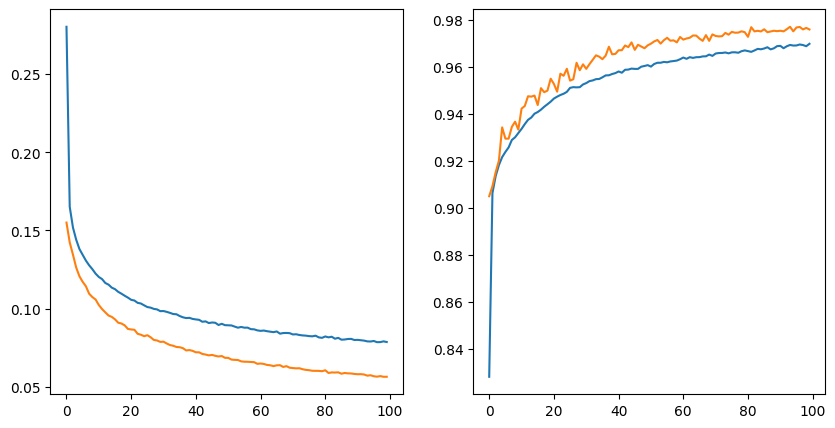

In [ ]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(history_df.loc[:, ['loss', 'val_loss']])
plt.subplot(122)
plt.plot(history_df.loc[:, ['recall', 'val_recall']])

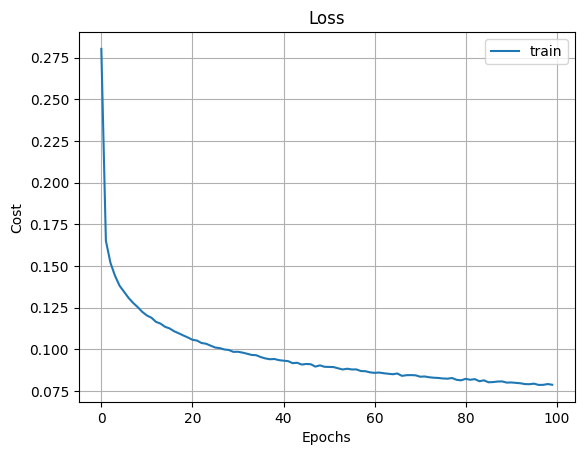

In [ ]:
plt.plot(history.history['loss'], label = "train")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title('Loss')
plt.grid()
plt.legend()
plt.show()

# Model Evaluation

In [ ]:
eval_loss, eval_acc = model.evaluate(X_test, y_test) # 피드백 대로, Test_Set 분리 한 후, accuracy를 확인 한 결과, accuracy가 감소 했다
print(f"evaluation_acc = {eval_acc}")
print(f"evaluation_loss = {eval_loss}")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0445 - recall: 0.8117
evaluation_acc = 0.8505747318267822
evaluation_loss = 0.04317895695567131


#Model Test

In [ ]:
y_pred = model.predict(X_test)

print(y_pred[0])
print(y_test)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
[0.00204415]
169876    0
127467    0
137900    0
21513     0
134700    0
         ..
230213    0
275519    0
148273    0
77261     0
73202     0
Name: Class, Length: 56962, dtype: int64


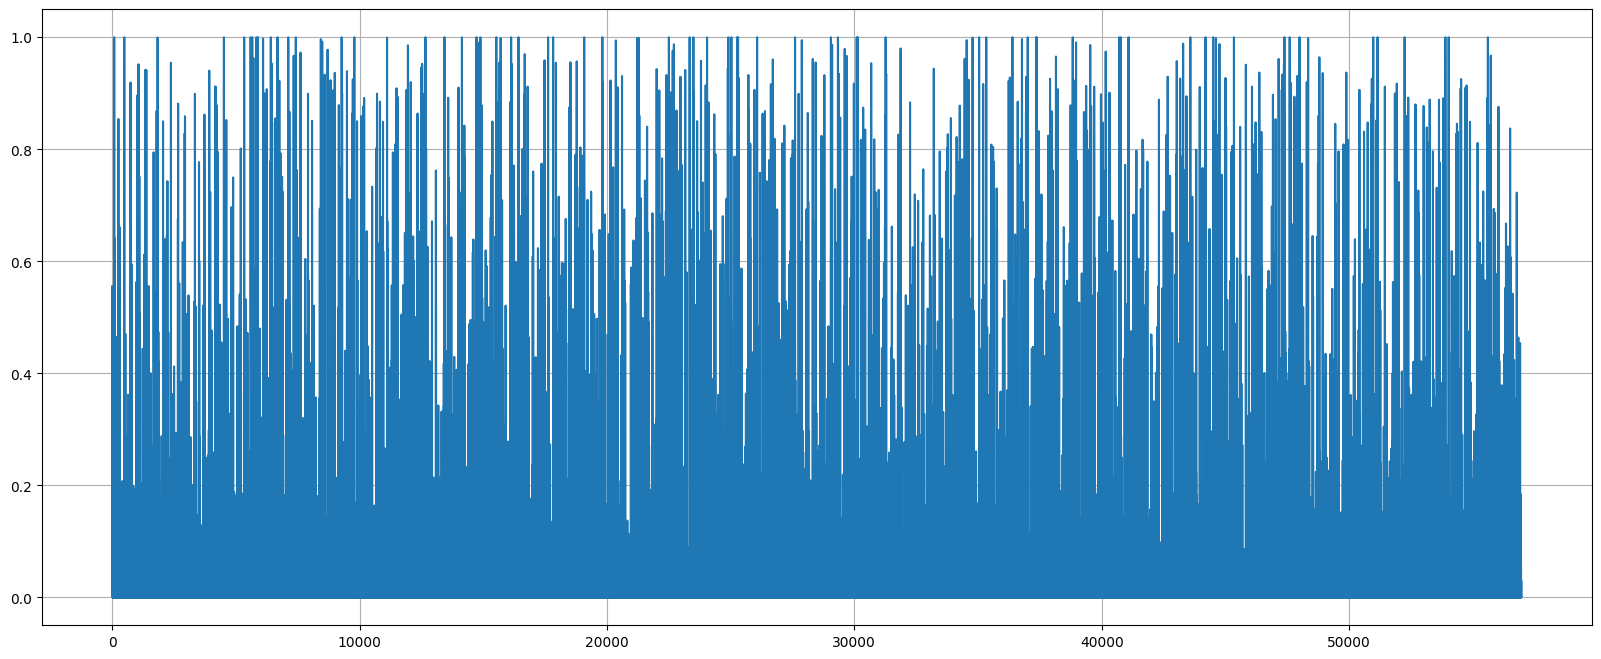

In [ ]:
plt.figure(figsize=(20,8)) #그래프 가로사이즈를 '10'으로 설정했을시, 0과1의 구별이 어려움
plt.plot(y_pred) #그래프모양 변경가능
plt.grid()
plt.show()

In [ ]:
y_pred_class = np.where(y_pred > 0.5, 1 , 0)
y_pred_class=pd.DataFrame(y_pred_class)
y_pred_class.value_counts()

,count
0,
0,56091
1,871


#Recall

In [ ]:
y_pred_class = np.where(y_pred > 0.5, 1 , 0) #0.5보다크면 1, 작으면 0
print(recall_score(y_test, y_pred_class))

0.8505747126436781


In [ ]:
y_test.value_counts()

,count
Class,
0,56875
1,87


#Confusion Matrix(피드백: 실제 판별건수를 혼동행렬에 추가)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


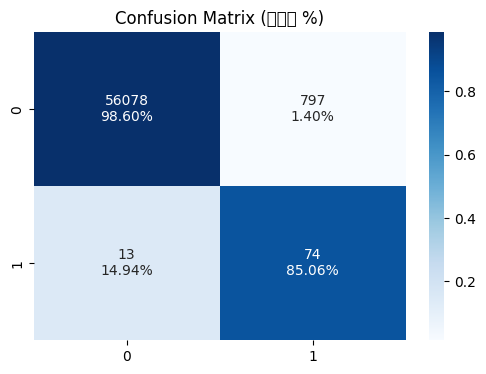

In [ ]:
# Confusion Matrix 계산 (건수)
cm_count = confusion_matrix(y_test, y_pred_class, labels=[0, 1], normalize=None)

# Confusion Matrix 계산 (%)
cm_percent = confusion_matrix(y_test, y_pred_class, labels=[0, 1], normalize='true')


plt.figure(figsize=(6, 4))


labels = np.asarray([f"{int(cm_count[i, j])}\n{cm_percent[i, j]:.2%}" for i in range(2) for j in range(2)]).reshape(2, 2)


sns.heatmap(cm_percent, annot=labels, fmt='', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.title("Confusion Matrix (건수와 %)")
plt.show()

# ROC Curve

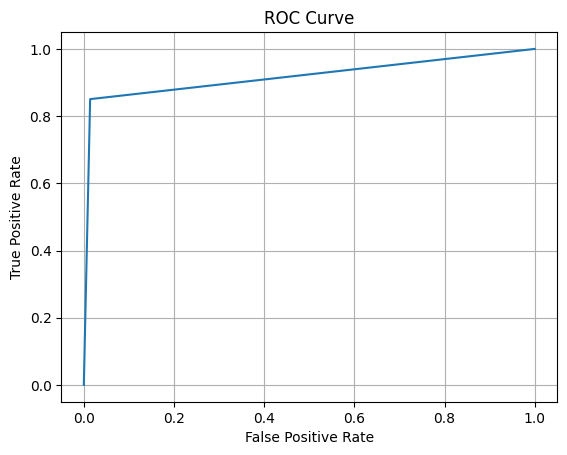

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_class)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

# AUC

In [ ]:
print(roc_auc_score(y_test, y_pred_class))

0.9182807629152456
